## Import Libraries

                                                               TASK-3                                                                                   

Build a decision tree classifier to predict whether a customer will purchase a product or service based on their demographic and behavioral data. Use a dataset such as the Bank Marketing dataset from the UCI Machine Learning Repository.

In [6]:
#import linear algebra and data manipulation libraries
import numpy as np
import pandas as pd

#import standard visualization
import matplotlib.pyplot as plt
import seaborn as sns

## Import Data

First of all to perform the analysis, we have to import the data:

In [7]:
#import dataset

df = pd.read_csv(r"C:\Users\boyal\OneDrive\Desktop\Task-3 Data Science\bank\bank.csv", delimiter=';')

In [8]:
df.rename(columns={'y':'deposit'}, inplace=True)

In [9]:
#display first 5 rows of dataset 
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


## Data Exploration

After we imported the dataset, we have to look at the total number of rows in the dataset and analyze the number of missing values.

In [10]:
# number of rows in dataset

print("Bank marketing dataset consists of {rows} rows.".format(rows = len(df)))

Bank marketing dataset consists of 4521 rows.


In [11]:
#find percentage of missing values for each column
missing_values = df.isnull().mean()*100

missing_values.sum()

0.0

So we see that there are no missing values.

### Categorical columns exploration

In the dataset we have both categorical and numerical columns. Let's look at the values of categorical columns first.

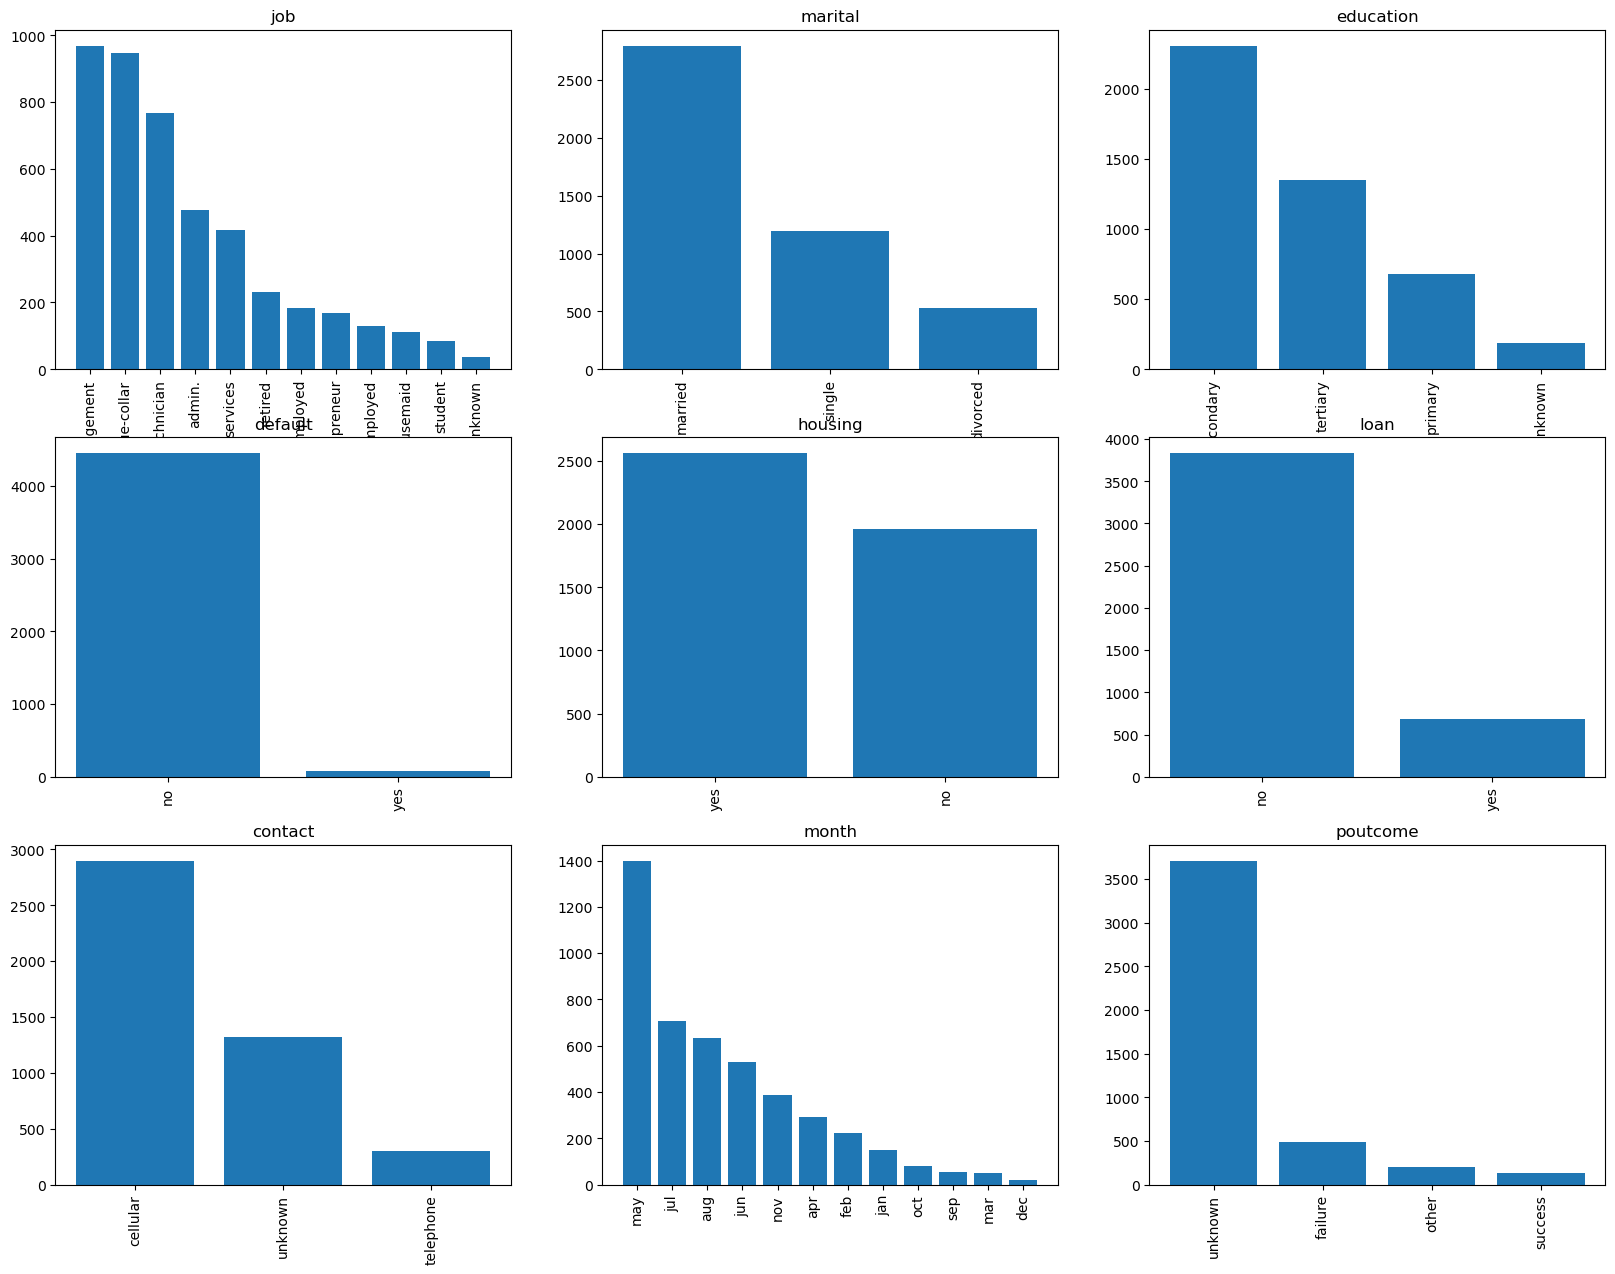

In [12]:
cat_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month','poutcome']

fig, axs = plt.subplots(3, 3, sharex=False, sharey=False, figsize=(20, 15))

counter = 0
for cat_column in cat_columns:
    value_counts = df[cat_column].value_counts()
    
    trace_x = counter // 3
    trace_y = counter % 3
    x_pos = np.arange(0, len(value_counts))
    
    axs[trace_x, trace_y].bar(x_pos, value_counts.values, tick_label = value_counts.index)
    
    axs[trace_x, trace_y].set_title(cat_column)
    
    for tick in axs[trace_x, trace_y].get_xticklabels():
        tick.set_rotation(90)
    
    counter += 1

plt.show()

### Numerical columns exploration

Now let's look at the numerical columns' values. The most convenient way to look at the numerical values is plotting histograms.

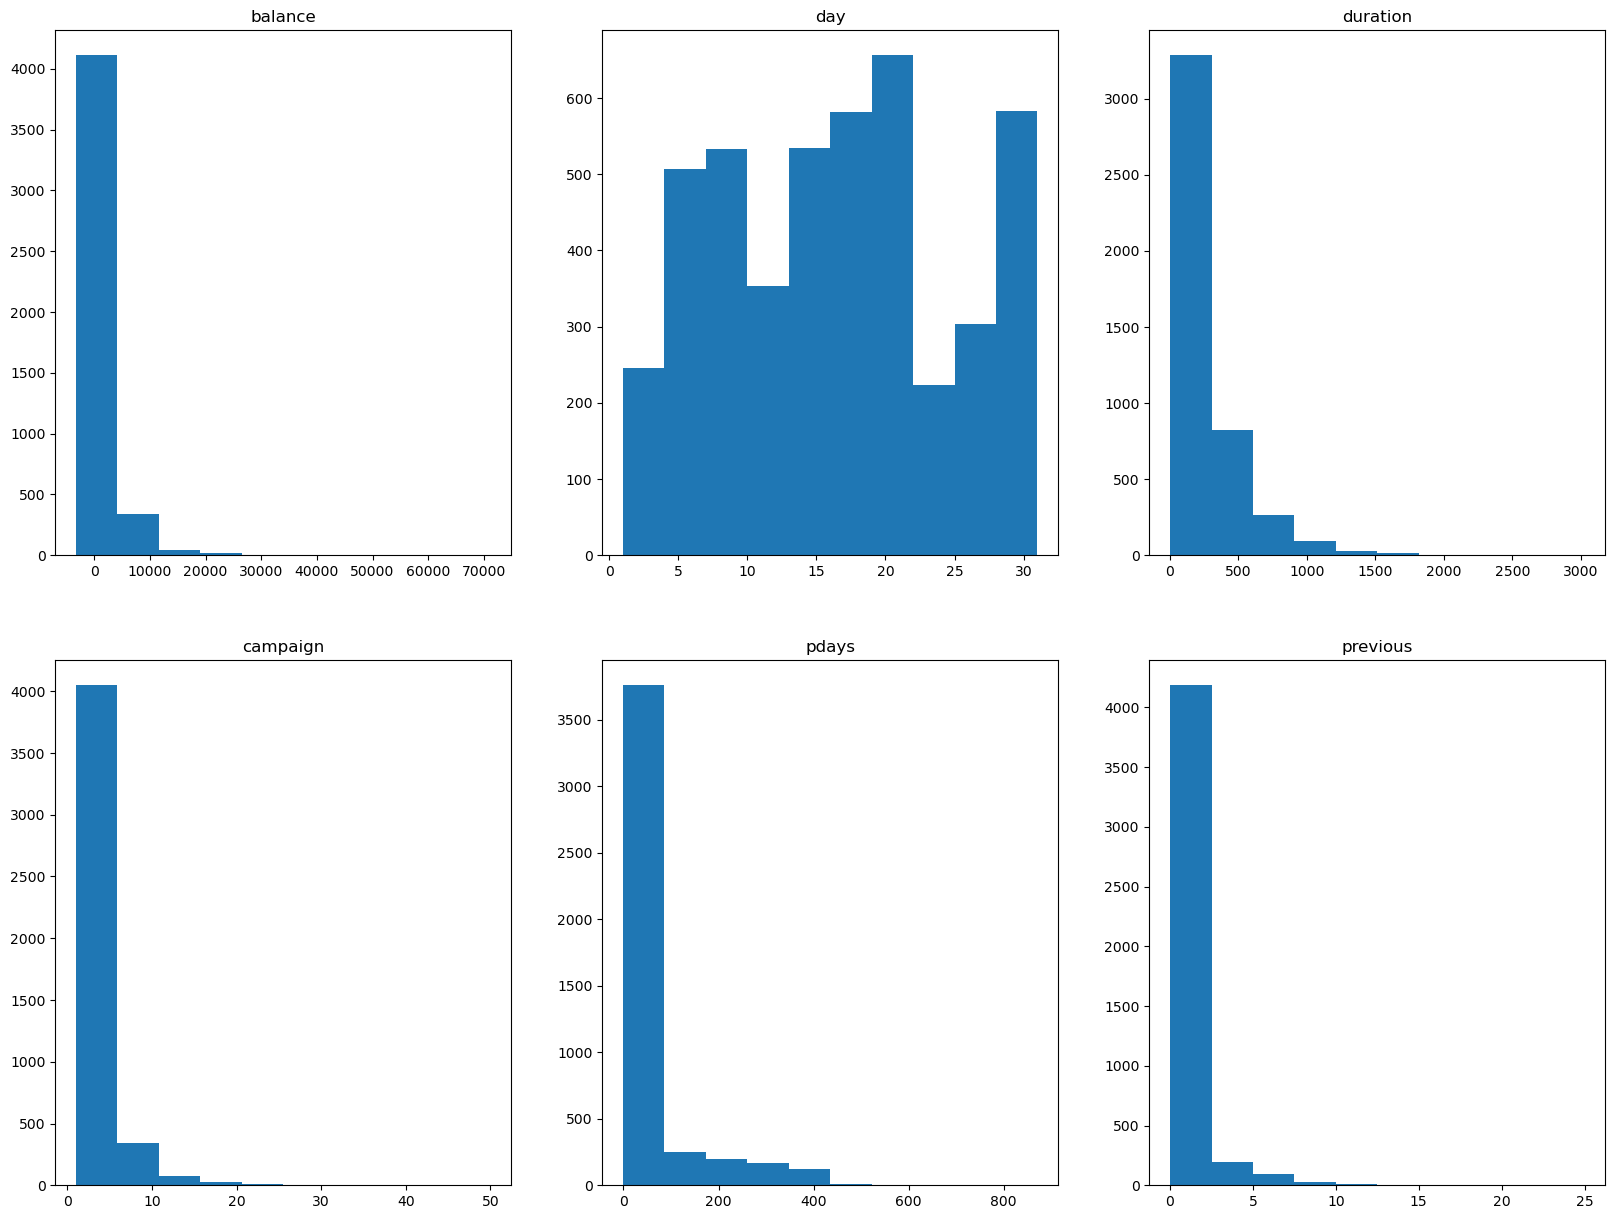

In [13]:
num_columns = ['balance', 'day','duration', 'campaign', 'pdays', 'previous']

fig, axs = plt.subplots(2, 3, sharex=False, sharey=False, figsize=(20, 15))

counter = 0
for num_column in num_columns:
    
    trace_x = counter // 3
    trace_y = counter % 3
    
    axs[trace_x, trace_y].hist(df[num_column])
    
    axs[trace_x, trace_y].set_title(num_column)
    
    counter += 1

plt.show()

We can see that numerical columns have outliers (especially 'pdays', 'campaign' and 'previous' columns). Possibly there are incorrect values (noisy data), so we should look closer at the data and decide how do we manage the noise.
<br> Let's look closer at the values of 'campaign', 'pdays' and 'previous' columns:

In [14]:
df[['pdays', 'campaign', 'previous']].describe()

,pdays,campaign,previous
count,4521.000000,4521.000000,4521.000000
mean,39.766645,2.793630,0.542579
std,100.121124,3.109807,1.693562
min,-1.000000,1.000000,0.000000
25%,-1.000000,1.000000,0.000000
50%,-1.000000,2.000000,0.000000
75%,-1.000000,3.000000,0.000000
max,871.000000,50.000000,25.000000


Percentage of 'pdays' values above 400:

In [15]:
len (df[df['pdays'] > 400] ) / len(df) * 100

0.57509400575094

'pdays' holds the number of days that passed by after the client was last contacted from a previous campaign
Looking closer into 'pdays' data we can see that:
* only 1.2% of values above 400. They are possibly outliers, so we should consider imputing something (possibly mean value) instead of these values.
* -1 possibly means that the client wasn't contacted before or stands for missing data.

Since we are not sure exactly what -1 means I suggest to drop this column, because -1 makes more than 50% of the values of the column.

Percentage of 'campaign' values above 20:

In [16]:
len (df[df['campaign'] > 34] ) / len(df) * 100

0.04423800044238001

'campaign' holds the number of contacts performed during this campaign and for this client (numeric, includes last contact)
Numbers for 'campaign' above 34 are clearly noise, so I suggest to impute them with average campaign values while data cleaning.

Percentage of 'previous' values above 20:

In [17]:
len (df[df['previous'] > 34] ) / len(df) * 100

0.0

'previous' holds the number of contacts performed before this campaign and for this client (numeric)
Numbers for 'previous' above 34 are also really strange, so I suggest to impute them with average campaign values while data cleaning.

### Analysis of the response column

It is very important to look at the response column, which holds the information, which we are going to predict. In our case we should look at 'deposit' column and compare its values to other columns. 
<br> First of all we should look at the number of 'yes' and 'no' values in the response column 'deposit'.

<Axes: title={'center': 'Deposit value counts'}, xlabel='deposit'>

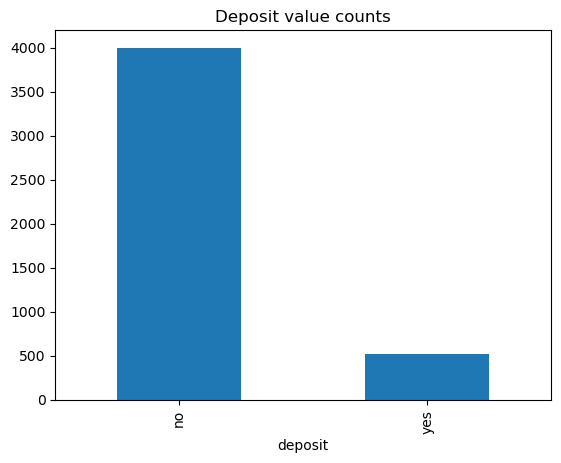

In [18]:
value_counts = df['deposit'].value_counts()

value_counts.plot.bar(title = 'Deposit value counts')

On the diagram we see that counts for 'yes' and 'no' values for 'deposit' are close, so we can use accuracy as a metric for a model, which predicts the campaign outcome.

Let's see how 'deposit' column value varies depending on other categorical columns' values:

<Axes: title={'center': 'Job and deposit'}, xlabel='job'>

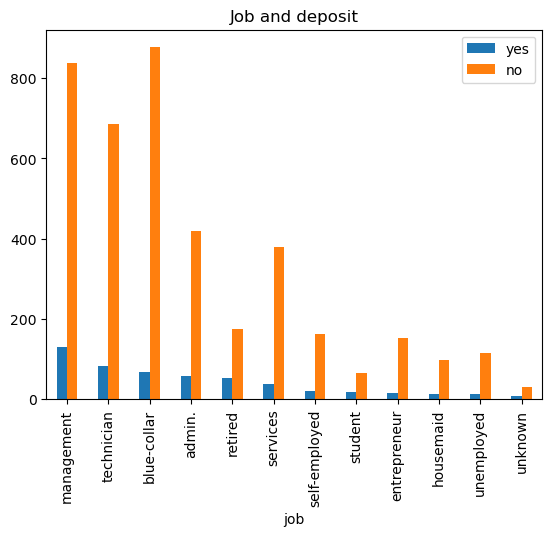

In [19]:
#job and deposit
j_df = pd.DataFrame()

j_df['yes'] = df[df['deposit'] == 'yes']['job'].value_counts()
j_df['no'] = df[df['deposit'] == 'no']['job'].value_counts()

j_df.plot.bar(title = 'Job and deposit')

<Axes: title={'center': 'Marital status and deposit'}, xlabel='marital'>

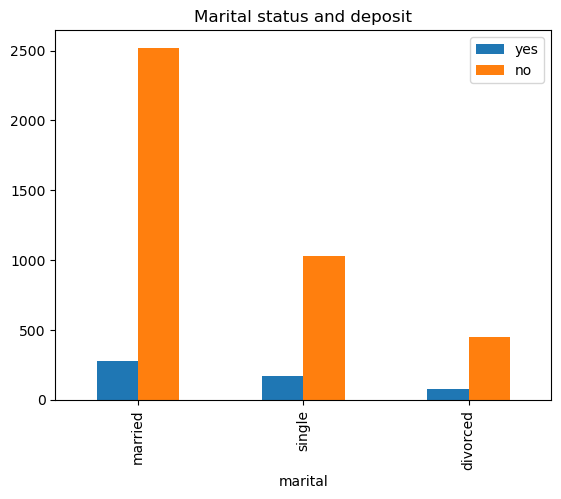

In [20]:
#marital status and deposit
j_df = pd.DataFrame()

j_df['yes'] = df[df['deposit'] == 'yes']['marital'].value_counts()
j_df['no'] = df[df['deposit'] == 'no']['marital'].value_counts()

j_df.plot.bar(title = 'Marital status and deposit')

<Axes: title={'center': 'Education and deposit'}, xlabel='education'>

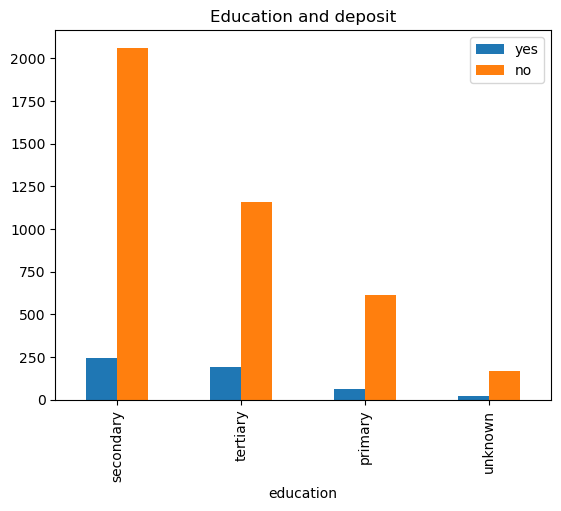

In [21]:
#education and deposit
j_df = pd.DataFrame()

j_df['yes'] = df[df['deposit'] == 'yes']['education'].value_counts()
j_df['no'] = df[df['deposit'] == 'no']['education'].value_counts()

j_df.plot.bar(title = 'Education and deposit')

<Axes: title={'center': 'Type of contact and deposit'}, xlabel='contact'>

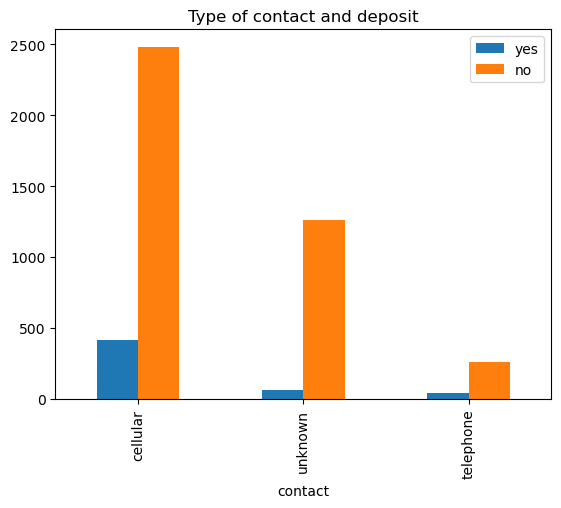

In [22]:
#type of contact and deposit
j_df = pd.DataFrame()

j_df['yes'] = df[df['deposit'] == 'yes']['contact'].value_counts()
j_df['no'] = df[df['deposit'] == 'no']['contact'].value_counts()

j_df.plot.bar(title = 'Type of contact and deposit')

Regarding the diagrams we can tell that according to our dataset:
1. Customers with 'blue-collar' and 'services' jobs are less likely to subscribe for term deposit.
2. Married customers are less likely to subscribe for term deposit.
3. Customers with 'cellular' type of contact are less likely to subscribe for term deposit.

Now let's look how numerical columns affect term deposit subscription.

In [23]:
#balance and deposit

b_df = pd.DataFrame()
b_df['balance_yes'] = (df[df['deposit'] == 'yes'][['deposit','balance']].describe())['balance']
b_df['balance_no'] = (df[df['deposit'] == 'no'][['deposit','balance']].describe())['balance']

b_df

,balance_yes,balance_no
count,521.000000,4000.000000
mean,1571.955854,1403.211750
std,2444.398956,3075.349313
min,-1206.000000,-3313.000000
25%,171.000000,61.000000
50%,710.000000,419.500000
75%,2160.000000,1407.000000
max,26965.000000,71188.000000


<Axes: title={'center': 'Balance and deposit statistics'}>

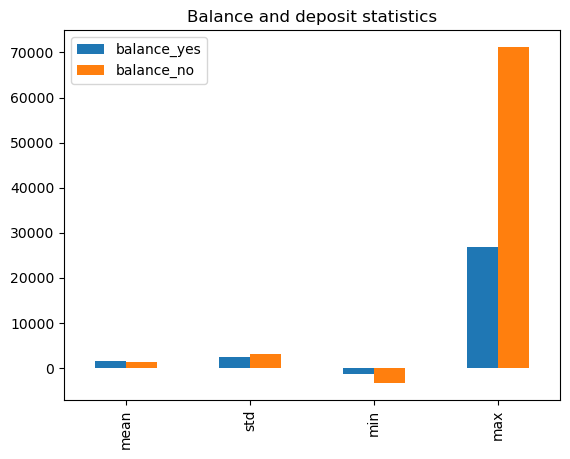

In [24]:
b_df.drop(['count', '25%', '50%', '75%']).plot.bar(title = 'Balance and deposit statistics')

In [25]:
#age and deposit

a_df = pd.DataFrame()
a_df['age_yes'] = (df[df['deposit'] == 'yes'][['deposit','age']].describe())['age']
a_df['age_no'] = (df[df['deposit'] == 'no'][['deposit','age']].describe())['age']

a_df

,age_yes,age_no
count,521.000000,4000.000000
mean,42.491363,40.998000
std,13.115772,10.188398
min,19.000000,19.000000
25%,32.000000,33.000000
50%,40.000000,39.000000
75%,50.000000,48.000000
max,87.000000,86.000000


<Axes: title={'center': 'Age and deposit statistics'}>

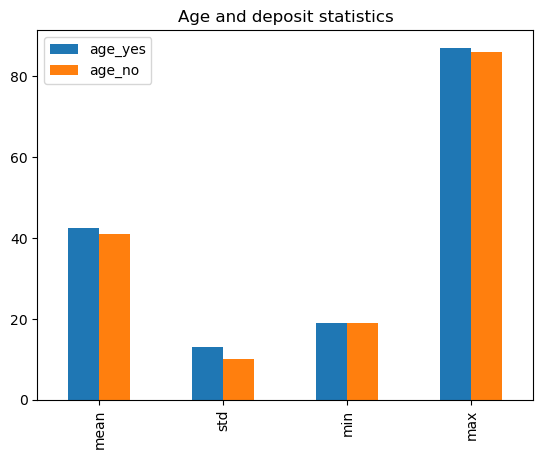

In [26]:
a_df.drop(['count', '25%', '50%', '75%']).plot.bar(title = 'Age and deposit statistics')

In [27]:
#number of contacts performed during this campaign ('campaign') and deposit
c_df = pd.DataFrame()
c_df['campaign_yes'] = (df[df['deposit'] == 'yes'][['deposit','campaign']].describe())['campaign']
c_df['campaign_no'] = (df[df['deposit'] == 'no'][['deposit','campaign']].describe())['campaign']

c_df

,campaign_yes,campaign_no
count,521.000000,4000.000000
mean,2.266795,2.862250
std,2.092071,3.212609
min,1.000000,1.000000
25%,1.000000,1.000000
50%,2.000000,2.000000
75%,3.000000,3.000000
max,24.000000,50.000000


<Axes: title={'center': 'Number of contacts performed during this campaign and deposit statistics'}>

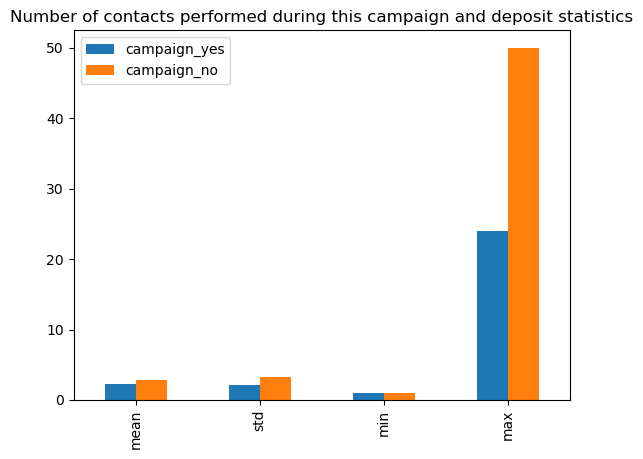

In [28]:
c_df.drop(['count', '25%', '50%', '75%']).plot.bar(title = 'Number of contacts performed during this campaign and deposit statistics')

In [29]:
#number of contacts performed during previous campaign ('previous') and deposit
p_df = pd.DataFrame()
p_df['previous_yes'] = (df[df['deposit'] == 'yes'][['deposit','previous']].describe())['previous']
p_df['previous_no'] = (df[df['deposit'] == 'no'][['deposit','previous']].describe())['previous']

p_df

,previous_yes,previous_no
count,521.000000,4000.000000
mean,1.090211,0.471250
std,2.055368,1.627371
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,2.000000,0.000000
max,14.000000,25.000000


<Axes: title={'center': 'Number of contacts performed during previous campaign and deposit statistics'}>

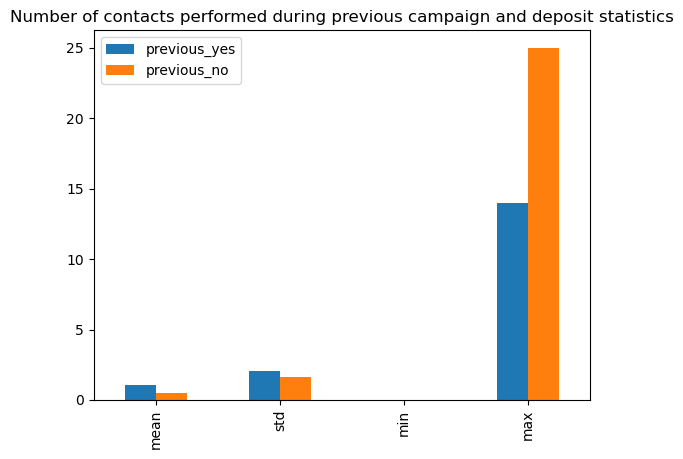

In [30]:
p_df.drop(['count', '25%', '50%', '75%']).plot.bar(title = 'Number of contacts performed during previous campaign and deposit statistics')

Looking at the diagrams above we can conclude that:
1. People who subscribed for term deposit tend to have greater balance and age values.
2. People who subscribed for term deposit tend to have fewer number of contacts during this campaign.

## Data Cleaning

Before we will be able to apply machine learning techniques, we should prepare the dataset for processing:
1. Convert columns with 'yes' and 'no' values to boolean columns;
2. Convert categorical columns into dummy variables.

In [31]:
def get_dummy_from_bool(row, column_name):
    ''' Returns 0 if value in column_name is no, returns 1 if value in column_name is yes'''
    return 1 if row[column_name] == 'yes' else 0

def get_correct_values(row, column_name, threshold, df):
    ''' Returns mean value if value in column_name is above threshold'''
    if row[column_name] <= threshold:
        return row[column_name]
    else:
        mean = df[df[column_name] <= threshold][column_name].mean()
        return mean

def clean_data(df):
    '''
    INPUT
    df - pandas dataframe containing bank marketing campaign dataset
    
    OUTPUT
    df - cleaned dataset:
    1. columns with 'yes' and 'no' values are converted into boolean variables;
    2. categorical columns are converted into dummy variables;
    3. drop irrelevant columns.
    4. impute incorrect values
    '''
    
    cleaned_df = df.copy()
    
    #convert columns containing 'yes' and 'no' values to boolean variables and drop original columns
    bool_columns = ['default', 'housing', 'loan', 'deposit']
    for bool_col in bool_columns:
        cleaned_df[bool_col + '_bool'] = df.apply(lambda row: get_dummy_from_bool(row, bool_col),axis=1)
    
    cleaned_df = cleaned_df.drop(columns = bool_columns)
    
    #convert categorical columns to dummies
    cat_columns = ['job', 'marital', 'education', 'contact', 'month', 'poutcome']
    
    for col in  cat_columns:
        cleaned_df = pd.concat([cleaned_df.drop(col, axis=1),
                                pd.get_dummies(cleaned_df[col], prefix=col, prefix_sep='_',
                                               drop_first=True, dummy_na=False)], axis=1)
    
    #drop irrelevant columns
    cleaned_df = cleaned_df.drop(columns = ['pdays'])
    
    #impute incorrect values and drop original columns
    cleaned_df['campaign_cleaned'] = df.apply(lambda row: get_correct_values(row, 'campaign', 34, cleaned_df),axis=1)
    cleaned_df['previous_cleaned'] = df.apply(lambda row: get_correct_values(row, 'previous', 34, cleaned_df),axis=1)
    
    cleaned_df = cleaned_df.drop(columns = ['campaign', 'previous'])
    
    return cleaned_df

In [32]:
#clean the dataset
cleaned_df = clean_data(df)
cleaned_df.head()

,age,balance,day,duration,default_bool,housing_bool,loan_bool,deposit_bool,job_blue-collar,job_entrepreneur,...,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown,campaign_cleaned,previous_cleaned
0,30,1787,19,79,0,0,0,0,False,False,...,False,False,False,True,False,False,False,True,1.0,0
1,33,4789,11,220,0,1,1,0,False,False,...,False,True,False,False,False,False,False,False,1.0,4
2,35,1350,16,185,0,1,0,0,False,False,...,False,False,False,False,False,False,False,False,1.0,1
3,30,1476,3,199,0,1,1,0,False,False,...,False,False,False,False,False,False,False,True,4.0,0
4,59,0,5,226,0,1,0,0,True,False,...,False,True,False,False,False,False,False,True,1.0,0


## Machine Learning for prediction of campaign outcome

### Classification model for the campaign outcome prediction

Now let's use cleaned datasets for prediction of campaign outcome with help of machine learning classification models. I will use __[XGBoost](https://xgboost.readthedocs.io/en/latest/)__, which is one of the most common machine learning libraries for modelling.
<br> Resulting model will also help me to understand, which features have the greatest importance for the prediction of the results of the campaing.

Create X and y datasets for training the model and split into train and test datasets.

In [33]:
X = cleaned_df.drop(columns = 'deposit_bool')
y = cleaned_df[['deposit_bool']]

In [34]:
TEST_SIZE = 0.3
RAND_STATE = 42

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_SIZE, random_state=RAND_STATE)

In [36]:
import xgboost

#train XGBoost model
xgb = xgboost.XGBClassifier(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

ModuleNotFoundError: No module named 'xgboost'

In [39]:
xgb.fit(X_train, y_train.squeeze().values)

NameError: name 'xgb' is not defined

In [40]:
y_train_preds = xgb.predict(X_train)
y_test_preds = xgb.predict(X_test)

NameError: name 'xgb' is not defined

In [41]:
from sklearn.metrics import accuracy_score
print('XGB accuracy score ofr train : %.3f and for test: %.3f' % (accuracy_score(y_train, y_train_preds),
                                                                 accuracy_score(y_test, y_test_preds)))

NameError: name 'y_train_preds' is not defined

### Get feature importance from the trained model

In [42]:
headers = ['name', 'score']
values = sorted(zip(X_train.columns, xgb.feature_importances_), key=lambda x: x[1]*-1)
xgb_feature_importances_ = pd.DataFrame(values, columns=headers)
xgb_feature_importances_

NameError: name 'xgb' is not defined

In [43]:
x_pos = np.arange(0, len(xgb_feature_importances_))
plt.bar(x_pos, xgb_feature_importances_['score'])
plt.xticks(x_pos, xgb_feature_importances_['name'])
plt.xticks(rotation=90)
plt.title('Feature Importance (XGB)')

plt.show()

NameError: name 'xgb_feature_importances_' is not defined